# Seismic Wave Propagation with CNN using U-Net

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import cv2
import numpy as np
import scipy.io
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout


from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.applications.resnet import preprocess_input

#import tensorflow_addons as tfa
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

## U-Net Image Segmentation Model Implementation

In [10]:
input_folders = ['2layers_binary_images/input', 
                 '3layers_binary_images/input',
                 '4layers_binary_images/input', 
                 '5layers_binary_images/input']

output_folders = ['2layers_binary_images/output', 
                  '3layers_binary_images/output',
                  '4layers_binary_images/output', 
                  '5layers_binary_images/output']

In [11]:
# Load images from input folders
image_data = []
target_size = (224, 224)

for folder in input_folders:
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = io.imread(img_path)
            image = resize(image, target_size, anti_aliasing=True)
            image_data.append(image)

In [12]:
# Load masks from output folders
mask = []

for folder in output_folders:
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            mask_path = os.path.join(folder, filename)
            mask_image = io.imread(mask_path)
            mask_image = resize(mask_image, target_size, anti_aliasing=True)
            mask_image = mask_image[:, :, :1]
            mask.append(mask_image)

In [13]:
image_data = np.array(image_data)
mask = np.array(mask)

In [14]:
# Split the data into training and testing sets
image_train, image_test, mask_train, mask_test = train_test_split(image_data, mask, test_size=0.2, random_state=42)

In [15]:
print("image_train shape:", image_train.shape)
print("image_test shape:", image_test.shape)
print("mask_train shape:", mask_train.shape)
print("mask_test shape:", mask_test.shape)

image_train shape: (160, 224, 224, 3)
image_test shape: (40, 224, 224, 3)
mask_train shape: (160, 224, 224, 1)
mask_test shape: (40, 224, 224, 1)


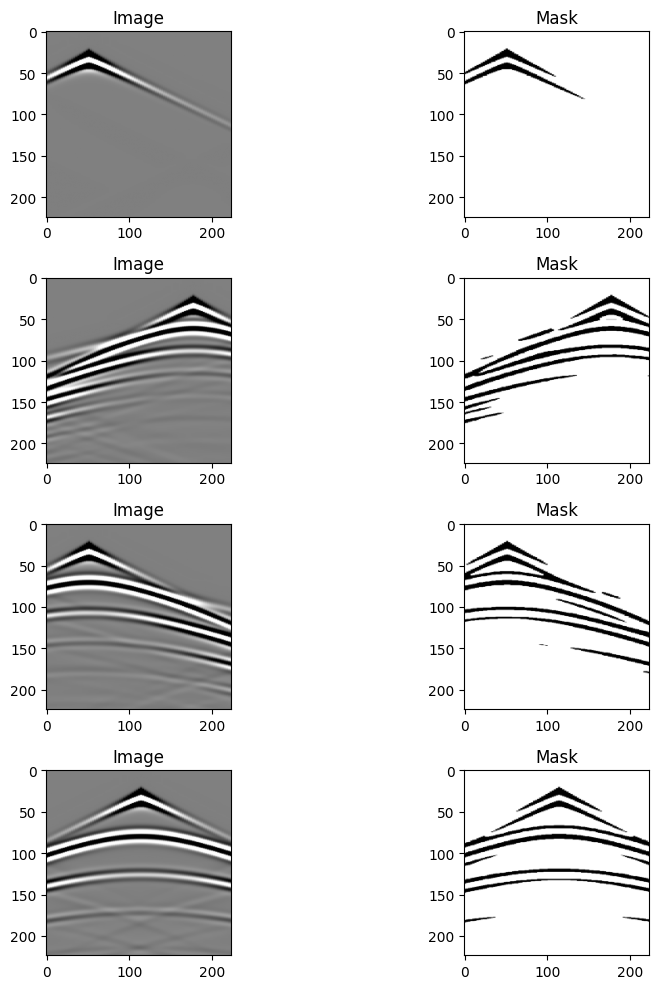

In [16]:
# Visualize sample images along with their corresponding masks
num_samples = 4 

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i in range(num_samples):
    axes[i, 0].imshow(image_data[i])
    axes[i, 0].axis('on')
    axes[i, 0].set_title('Image')

    axes[i, 1].imshow(mask[i], cmap='gray')
    axes[i, 1].axis('on')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()

In [17]:
# Define the UNet model architecture
def unet_model(input_size=(224, 224, 3)):
    inputs = keras.Input(input_size)
    
    c1 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = layers.Dropout(0.1) (c1)
    c1 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = layers.MaxPooling2D((2, 2)) (c1)

    c2 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = layers.Dropout(0.1) (c2)
    c2 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = layers.MaxPooling2D((2, 2)) (c2)

    c3 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = layers.Dropout(0.2) (c3)
    c3 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)

    c4 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = layers.Dropout(0.2) (c4)
    c4 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = layers.Dropout(0.3) (c5)
    c5 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = layers.Dropout(0.2) (c6)
    c6 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = layers.Dropout(0.2) (c7)
    c7 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = layers.Dropout(0.1) (c8)
    c8 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = layers.Dropout(0.1) (c9)
    c9 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
# Create the UNet model
UNet_model = unet_model()

In [19]:
# Compile the model
UNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
# Train the model with early stopping
history = UNet_model.fit(image_train, mask_train, epochs=20, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20


8/8 [==============================] - 10s 893ms/step - loss: 0.3209 - accuracy: 0.8056 - val_loss: 0.1460 - val_accuracy: 0.9007
Epoch 2/20
8/8 [==============================] - 7s 928ms/step - loss: 0.1086 - accuracy: 0.8967 - val_loss: 0.1122 - val_accuracy: 0.9059
Epoch 3/20
8/8 [==============================] - 7s 937ms/step - loss: 0.0521 - accuracy: 0.8997 - val_loss: 0.1042 - val_accuracy: 0.9071
Epoch 4/20
8/8 [==============================] - 8s 955ms/step - loss: 0.0400 - accuracy: 0.8996 - val_loss: 0.0830 - val_accuracy: 0.9080
Epoch 5/20
8/8 [==============================] - 8s 984ms/step - loss: 0.0355 - accuracy: 0.8997 - val_loss: 0.0798 - val_accuracy: 0.9082
Epoch 6/20
8/8 [==============================] - 7s 947ms/step - loss: 0.0331 - accuracy: 0.9000 - val_loss: 0.0737 - val_accuracy: 0.9082
Epoch 7/20
8/8 [==============================] - 7s 930ms/step - loss: 0.0317 - accuracy: 0.9002 - val_loss: 0.0731 - val_accuracy: 0.9082
Epoch 8/20
8/8 [=

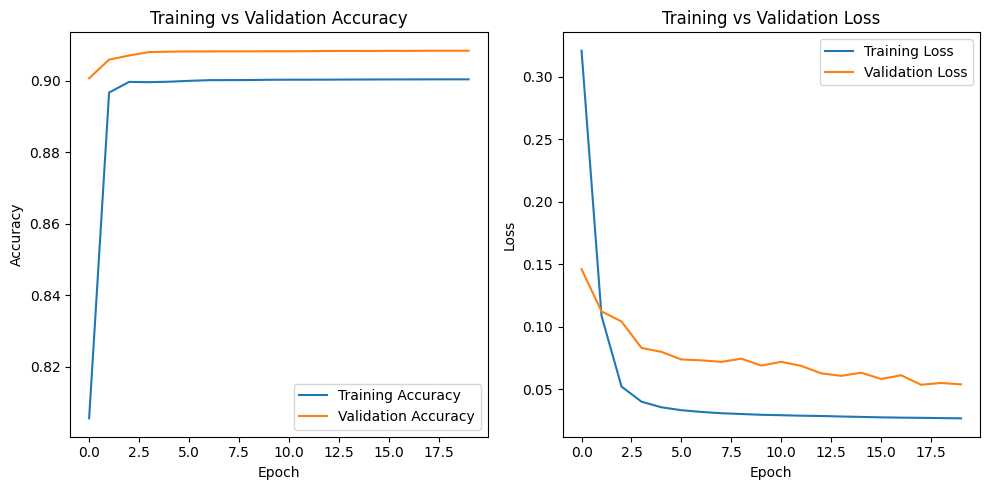

In [22]:
# Plot training vs test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot training vs test loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Evaluate the model on test data
loss, accuracy = UNet_model.evaluate(image_test, mask_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2/2 [==============================] - 1s 121ms/step - loss: 0.0607 - accuracy: 0.9026
Test Loss: 0.06072996184229851
Test Accuracy: 0.9026217460632324


1/1 [==============================] - 0s 300ms/step


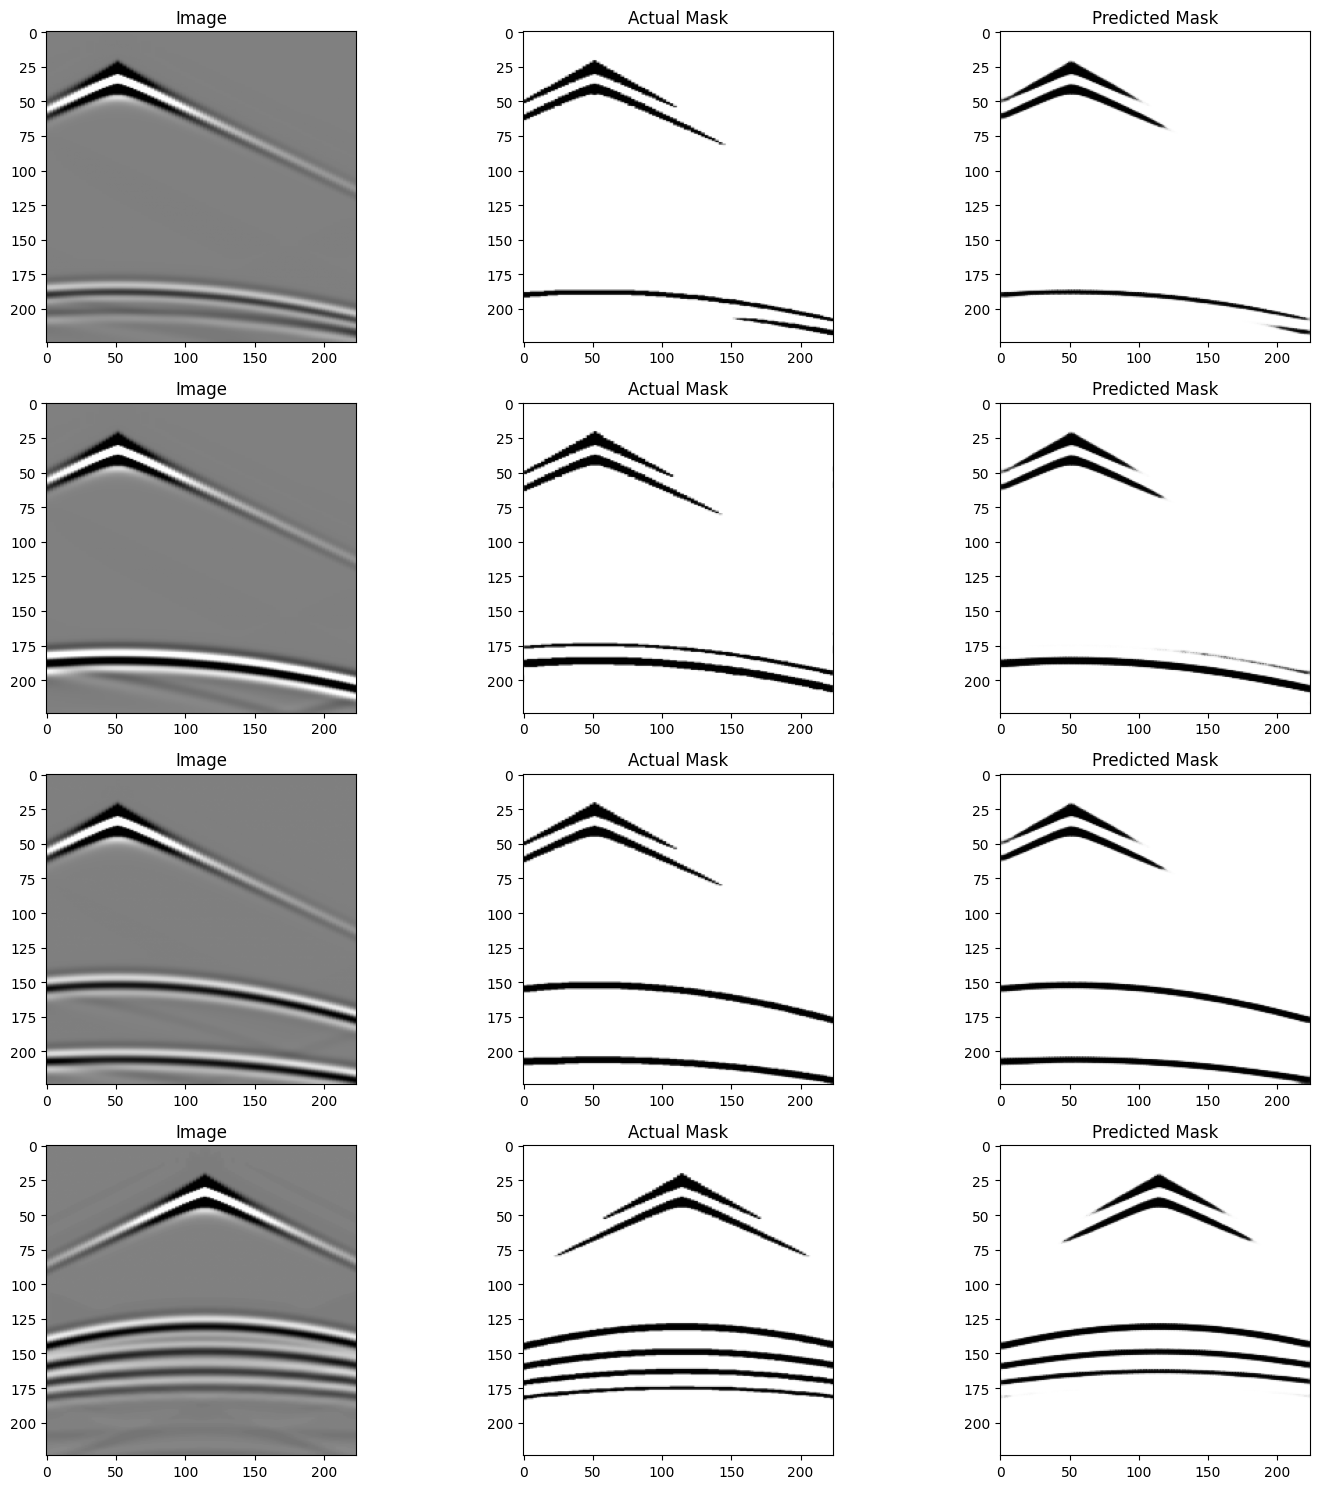

In [24]:
# Visualize sample images along with their actual and predicted masks
num_samples = 4

predicted_masks = UNet_model.predict(image_test[:num_samples])

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))

for i in range(num_samples):
    axes[i, 0].imshow(image_test[i])
    axes[i, 0].axis('on')
    axes[i, 0].set_title('Image')

    axes[i, 1].imshow(mask_test[i], cmap='gray')
    axes[i, 1].axis('on')
    axes[i, 1].set_title('Actual Mask')

    axes[i, 2].imshow(predicted_masks[i], cmap='gray')
    axes[i, 2].axis('on')
    axes[i, 2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

In [25]:
predicted_masks.shape

(4, 224, 224, 1)

## CNN Implementation

### Data Preprocessing

In [27]:
# Load and preprocess images
folder_paths = ['Filtered Image Folders/2layers_images', 
                'Filtered Image Folders/3layers_images', 
                'Filtered Image Folders/4layers_images', 
                'Filtered Image Folders/5layers_images']

images = []
target_size = (224, 224)

for folder in folder_paths:
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            image = io.imread(img_path)
            image = resize(image, target_size, anti_aliasing=True)
            images.append(image)
            
images = np.array(images)

In [28]:
images.shape

(300, 224, 224, 3)

In [29]:
# Encode images into the binary format using U-Net
UNet_masks = UNet_model.predict(images)

10/10 [==============================] - 4s 349ms/step


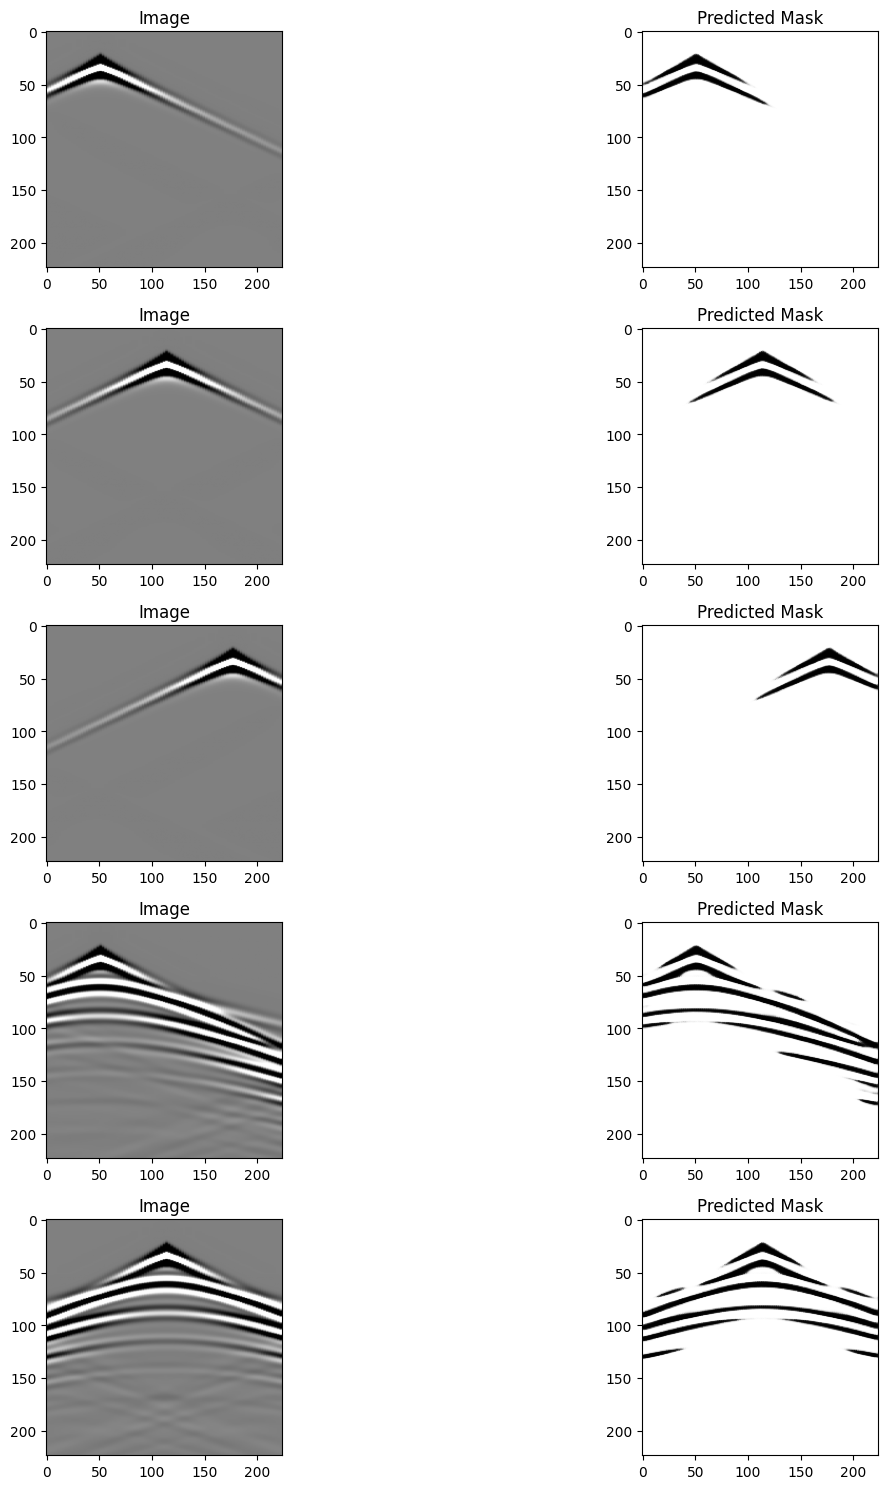

In [30]:
# Visualize sample images along with their corresponding predicted masks
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

for i in range(5):
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('on')
    axes[i, 0].set_title('Image')

    axes[i, 1].imshow(UNet_masks[i], cmap='gray')
    axes[i, 1].axis('on')
    axes[i, 1].set_title('Predicted Mask')

plt.tight_layout()
plt.show()

In [31]:
UNet_masks.shape

(300, 224, 224, 1)

In [32]:
# Extract classes from the predicted data
layers2_images = UNet_masks[:75, :]
layers3_images = UNet_masks[75:150, :]
layers4_images = UNet_masks[150:225, :]
layers5_images = UNet_masks[225:300, :]

In [56]:
# 2 Layers
layers2_reshaped = layers2_images.reshape(-1, 3, 224, 224)


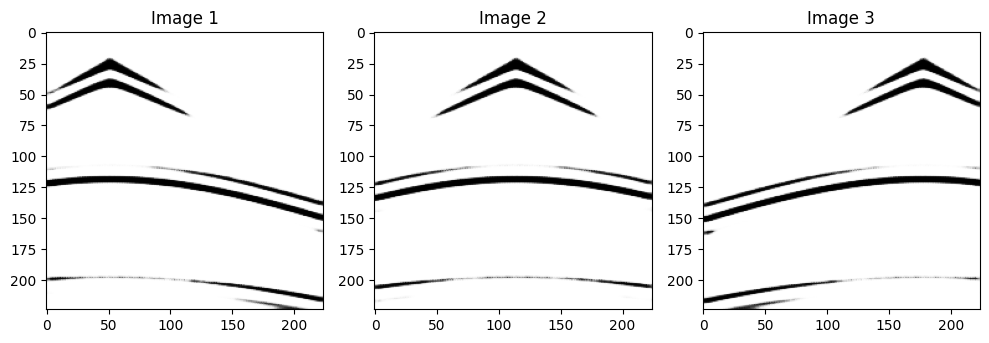

In [34]:
sample_images = layers2_reshaped[7]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i in range(3):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i].axis('on')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

In [35]:
# 3 Layers
layers3_col1 = layers3_images[:25, :]
layers3_col2 = layers3_images[25:50, :]
layers3_col3 = layers3_images[50:75, :]

layers3_reshaped = np.stack((layers3_col1, layers3_col2, layers3_col3), axis=1).reshape(25, 3, 224, 224)

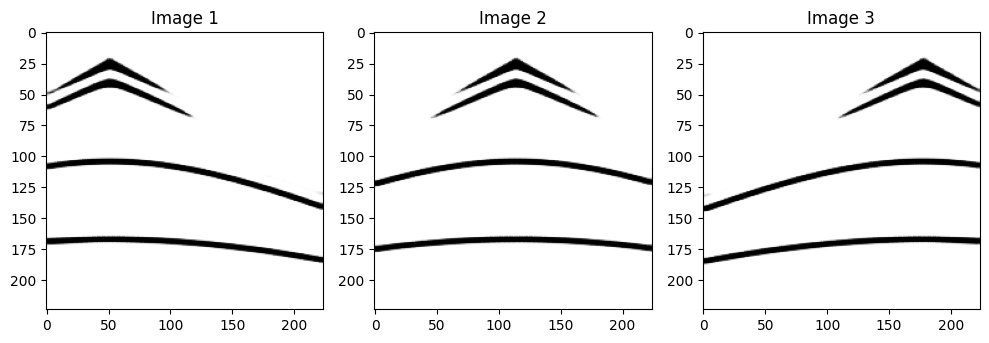

In [36]:
sample_images = layers3_reshaped[7]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i in range(3):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i].axis('on')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

In [37]:
# 4 Layers
layers4_reshaped = layers4_images.reshape(-1, 3, 224, 224)

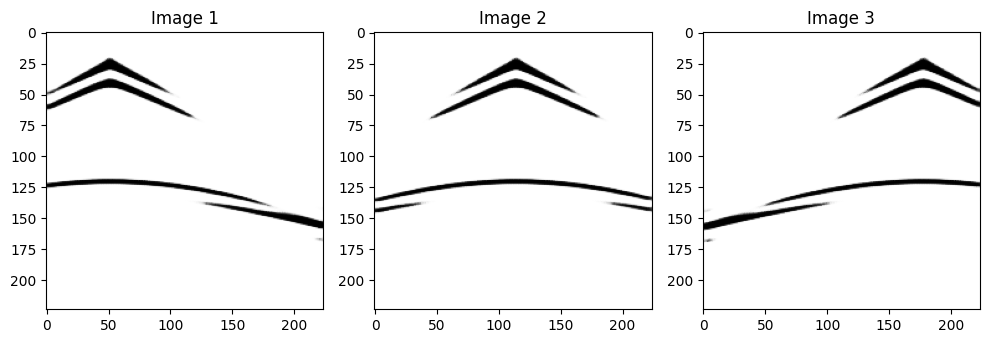

In [38]:
sample_images = layers4_reshaped[7]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i in range(3):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i].axis('on')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

In [39]:
# 5 Layers
layers5_col1 = layers5_images[:25, :]
layers5_col2 = layers5_images[25:50, :]
layers5_col3 = layers5_images[50:75, :]

layers5_reshaped = np.stack((layers5_col1, layers5_col2, layers5_col3), axis=1).reshape(25, 3, 224, 224)

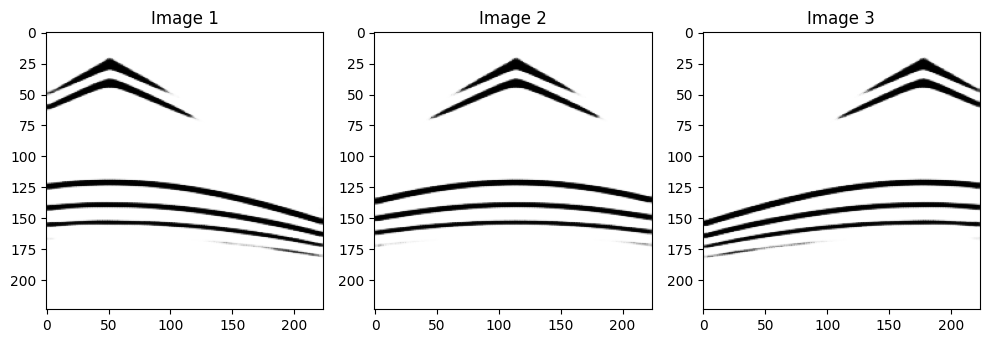

In [40]:
sample_images = layers5_reshaped[7]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i in range(3):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i].axis('on')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

In [41]:
# Define labels
layers2_labels = np.full((25,), "2 layers")
layers3_labels = np.full((25,), "3 layers")
layers4_labels = np.full((25,), "4 layers")
layers5_labels = np.full((25,), "5 layers")

In [42]:
# Combine data and labels from different classes
x_data = np.concatenate((layers2_reshaped, layers3_reshaped, layers4_reshaped, layers5_reshaped), axis=0)
y_data = np.concatenate((layers2_labels, layers3_labels, layers4_labels, layers5_labels), axis=0)

In [43]:
# Convert labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data)

In [44]:
print(x_data.shape, y_data.shape)

(100, 3, 224, 224) (100,)


In [45]:
# Split data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [46]:
print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)
print("Test data shape:", x_test.shape, y_test.shape)

Training data shape: (60, 3, 224, 224) (60,)
Validation data shape: (20, 3, 224, 224) (20,)
Test data shape: (20, 3, 224, 224) (20,)


In [47]:
# Transpose the data to meet input shape requirements
x_train = np.transpose(x_train, (0, 2, 3, 1))
x_val = np.transpose(x_val, (0, 2, 3, 1))
x_test = np.transpose(x_test, (0, 2, 3, 1))

print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)
print("Test data shape:", x_test.shape, y_test.shape)

Training data shape: (60, 224, 224, 3) (60,)
Validation data shape: (20, 224, 224, 3) (20,)
Test data shape: (20, 224, 224, 3) (20,)


## Training and Testing CNN Models

In [54]:
# Configure hyperparameters
image_size = 224
batch_size = 16
num_epochs = 20
lr = 0.0001

e = 100
batch = 32
# inp_shape = (89, 1000, 3)
inp_shape = (224, 224, 3)
# inp_shape = (64, 64, 3)
class_num = 4
metric_list = ['accuracy']

### Data Augmentation

In [49]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest'
)

In [50]:
# Fit the data generator to training data
datagen.fit(x_train)

In [51]:
# Create a generator that will yield augmented data batches during training
augmented_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

### Early stopping

In [52]:
# Define early stopping callback
callbacks = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Resnet 50

In [70]:
#resnet 50
base_ResNet50 = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = inp_shape)
# Add dropout layer
dropout_rate = 0.1
base_ResNet50 = keras.Model(inputs=base_ResNet50.input, outputs=Dropout(dropout_rate)(base_ResNet50.layers[-2].output))
#freeze all layers in base model
for layer in base_ResNet50.layers[:-2]:
    layer.trainable = False #freeze layers

x = layers.Flatten()(base_ResNet50.output)
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions_ResNet50 = layers.Dense(class_num, activation = 'softmax')(x)

head_ResNet50 = Model(inputs = base_ResNet50.input, outputs = predictions_ResNet50)
head_ResNet50.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=metric_list)

history_resnet50 = head_ResNet50.fit(x_train, y_train, batch_size=batch, epochs=e, validation_data=(x_val, y_val), callbacks=callbacks)
head_ResNet50.save('models/model_resnet50.h5')

Epoch 1/100
2/2 [==============================] - 8s 4s/step - loss: 388.5490 - accuracy: 0.3667 - val_loss: 2117.9724 - val_accuracy: 0.3000
Epoch 2/100
2/2 [==============================] - 5s 3s/step - loss: 1933.7333 - accuracy: 0.2833 - val_loss: 1103.1040 - val_accuracy: 0.3000
Epoch 3/100
2/2 [==============================] - 5s 3s/step - loss: 1148.8556 - accuracy: 0.1500 - val_loss: 841.6014 - val_accuracy: 0.1000
Epoch 4/100
2/2 [==============================] - 5s 3s/step - loss: 643.4039 - accuracy: 0.2833 - val_loss: 648.3094 - val_accuracy: 0.3000
Epoch 5/100
2/2 [==============================] - 5s 3s/step - loss: 582.8669 - accuracy: 0.2333 - val_loss: 188.4567 - val_accuracy: 0.3000
Epoch 6/100
2/2 [==============================] - 5s 3s/step - loss: 445.1869 - accuracy: 0.2500 - val_loss: 543.6693 - val_accuracy: 0.3000
Epoch 7/100
2/2 [==============================] - 5s 3s/step - loss: 402.6564 - accuracy: 0.2833 - val_loss: 692.9362 - val_accuracy: 0.1000
Ep

## Resnet152 

In [67]:
#resnet 152 
base_ResNet152 = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = inp_shape)
# Add dropout layer
dropout_rate = 0.1
# base_ResNet152 = keras.Model(inputs=base_ResNet152.input, outputs=Dropout(dropout_rate)(base_ResNet152.layers[-2].output))

for layer in base_ResNet152.layers[:-1]:
    layer.trainable = False 

x = layers.Flatten()(base_ResNet152.output)
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # Apply L2 regularization
predictions_ResNet152 = layers.Dense(class_num, activation = 'softmax')(x)

head_ResNet152 = Model(inputs = base_ResNet152.input, outputs = predictions_ResNet152)
head_ResNet152.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=metric_list)


history_resnet152 = head_ResNet152.fit(x_train, y_train, batch_size=batch, epochs=e, validation_data=(x_val, y_val), callbacks=callbacks)
head_ResNet152.save('models/model_resnet152.h5')

Epoch 1/100
2/2 [==============================] - 19s 8s/step - loss: 39.3778 - accuracy: 0.3000 - val_loss: 49.6601 - val_accuracy: 0.3000
Epoch 2/100
2/2 [==============================] - 9s 5s/step - loss: 74.6257 - accuracy: 0.2500 - val_loss: 25.7126 - val_accuracy: 0.3000
Epoch 3/100
2/2 [==============================] - 9s 5s/step - loss: 32.3782 - accuracy: 0.2833 - val_loss: 19.1691 - val_accuracy: 0.4500
Epoch 4/100
2/2 [==============================] - 9s 5s/step - loss: 17.5221 - accuracy: 0.4000 - val_loss: 18.1856 - val_accuracy: 0.2000
Epoch 5/100
2/2 [==============================] - 9s 5s/step - loss: 11.8321 - accuracy: 0.5500 - val_loss: 7.4664 - val_accuracy: 0.2500
Epoch 6/100
2/2 [==============================] - 8s 5s/step - loss: 8.3737 - accuracy: 0.4000 - val_loss: 7.4903 - val_accuracy: 0.6000
Epoch 7/100
2/2 [==============================] - 8s 5s/step - loss: 6.0190 - accuracy: 0.6667 - val_loss: 8.6954 - val_accuracy: 0.4000
Epoch 8/100
2/2 [=======

## VGG16

In [65]:
#VGG 16
base_VGG16 = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = inp_shape)

for layer in base_VGG16.layers[:-2]:
    layer.trainable = False

x = layers.Flatten()(base_VGG16.output)
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions_VGG16 = layers.Dense(class_num, activation = 'softmax')(x)

head_VGG16 = Model(inputs = base_VGG16.input, outputs = predictions_VGG16)
head_VGG16.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=metric_list)

history_VGG16 = head_VGG16.fit(x_train, y_train, batch_size=batch, epochs=e, validation_data=(x_val, y_val), callbacks=callbacks)
head_VGG16.save('models/model_VGG16.h5')

Epoch 1/100
2/2 [==============================] - 7s 4s/step - loss: 28.3973 - accuracy: 0.2667 - val_loss: 29.4990 - val_accuracy: 0.3000
Epoch 2/100
2/2 [==============================] - 6s 3s/step - loss: 24.8279 - accuracy: 0.2500 - val_loss: 14.0806 - val_accuracy: 0.3000
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 12.3132 - accuracy: 0.3500 - val_loss: 10.1716 - val_accuracy: 0.1500
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 8.9407 - accuracy: 0.4000 - val_loss: 8.0120 - val_accuracy: 0.2500
Epoch 5/100
2/2 [==============================] - 6s 3s/step - loss: 7.1686 - accuracy: 0.2833 - val_loss: 6.4001 - val_accuracy: 0.3000
Epoch 6/100
2/2 [==============================] - 6s 3s/step - loss: 5.8020 - accuracy: 0.5833 - val_loss: 5.6394 - val_accuracy: 0.3500
Epoch 7/100
2/2 [==============================] - 6s 3s/step - loss: 5.0753 - accuracy: 0.6000 - val_loss: 5.1702 - val_accuracy: 0.5000
Epoch 8/100
2/2 [===========

## VGG19

In [66]:
#VGG19
base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = inp_shape)
# Add dropout layer
dropout_rate = 0.1
# base_VGG19 = keras.Model(inputs=base_VGG19.input, outputs=Dropout(dropout_rate)(base_VGG19.layers[-2].output))
for layer in base_VGG19.layers[:-1]:
    layer.trainable = False

x = layers.Flatten()(base_VGG19.output)
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
predictions_VGG19 = layers.Dense(class_num, activation = 'softmax')(x)

head_VGG19 = Model(inputs = base_VGG19.input, outputs = predictions_VGG19)
head_VGG19.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=metric_list)

history_VGG19 = head_VGG19.fit(x_train, y_train, batch_size=batch, epochs=e, validation_data=(x_val, y_val), callbacks=callbacks)
head_VGG19.save('models/model_VGG19.h5')

Epoch 1/100
2/2 [==============================] - 8s 4s/step - loss: 29.2558 - accuracy: 0.3167 - val_loss: 41.0128 - val_accuracy: 0.3000
Epoch 2/100
2/2 [==============================] - 7s 4s/step - loss: 34.0492 - accuracy: 0.2333 - val_loss: 17.9858 - val_accuracy: 0.3000
Epoch 3/100
2/2 [==============================] - 7s 4s/step - loss: 14.6783 - accuracy: 0.3500 - val_loss: 16.3329 - val_accuracy: 0.3000
Epoch 4/100
2/2 [==============================] - 7s 4s/step - loss: 13.3728 - accuracy: 0.4333 - val_loss: 14.3421 - val_accuracy: 0.3500
Epoch 5/100
2/2 [==============================] - 7s 4s/step - loss: 10.5893 - accuracy: 0.5000 - val_loss: 9.4296 - val_accuracy: 0.4000
Epoch 6/100
2/2 [==============================] - 7s 4s/step - loss: 6.7531 - accuracy: 0.5167 - val_loss: 7.3962 - val_accuracy: 0.3500
Epoch 7/100
2/2 [==============================] - 7s 4s/step - loss: 5.9772 - accuracy: 0.6167 - val_loss: 6.3960 - val_accuracy: 0.4000
Epoch 8/100
2/2 [========

## Densnet121

In [61]:
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import DenseNet121

#densnet121
base_densenet = tf.keras.applications.densenet.DenseNet121 (weights = 'imagenet', include_top = False, input_shape = inp_shape)
# Add dropout layer
dropout_rate = 0.1
base_densenet = keras.Model(inputs=base_densenet.input, outputs=Dropout(dropout_rate)(base_densenet.layers[-2].output))

for layer in base_densenet.layers[:-2]:
    layer.trainable = False

x = layers.Flatten()(base_densenet.output)

# Apply L2 regularization
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)


predictions_densenet = layers.Dense(class_num, activation = 'softmax')(x)

head_densenet = Model(inputs = base_densenet.input, outputs = predictions_densenet)
head_densenet.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=metric_list)

history_densenet = head_densenet.fit(x_train, y_train, batch_size=batch, epochs=e, validation_data=(x_val, y_val), callbacks=callbacks)
head_densenet.save('models/model_densenet.h5')

Epoch 1/100
2/2 [==============================] - 10s 4s/step - loss: 86.9615 - accuracy: 0.2500 - val_loss: 113.5256 - val_accuracy: 0.3500
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 180.0047 - accuracy: 0.3667 - val_loss: 85.1609 - val_accuracy: 0.1000
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 64.5757 - accuracy: 0.5667 - val_loss: 62.9346 - val_accuracy: 0.4000
Epoch 4/100
2/2 [==============================] - 3s 2s/step - loss: 51.1784 - accuracy: 0.5000 - val_loss: 39.8120 - val_accuracy: 0.4500
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 35.4953 - accuracy: 0.5333 - val_loss: 37.9118 - val_accuracy: 0.2500
Epoch 6/100
2/2 [==============================] - 4s 2s/step - loss: 28.2592 - accuracy: 0.6833 - val_loss: 35.8540 - val_accuracy: 0.2500
Epoch 7/100
2/2 [==============================] - 4s 2s/step - loss: 22.2116 - accuracy: 0.7333 - val_loss: 29.0506 - val_accuracy: 0.4500
Epoch 8/100
2/2 [

## Mobilenet_v3

In [71]:
#mobilenet_v3
base_mobilenet_v3 = tf.keras.applications.MobileNetV3Small(weights = 'imagenet', include_top = False, input_shape = inp_shape)
for layer in base_mobilenet_v3.layers[:-1]:
    layer.trainable = False
# Add dropout layer
dropout_rate = 0.1
base_mobilenet_v3 = keras.Model(inputs=base_mobilenet_v3.input, outputs=Dropout(dropout_rate)(base_mobilenet_v3.layers[-2].output))
x = layers.Flatten()(base_mobilenet_v3.output)
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

predictions_mobilenet_v3 = layers.Dense(class_num, activation = 'softmax')(x)
head_mobilenet_v3 = Model(inputs = base_mobilenet_v3.input, outputs = predictions_mobilenet_v3)
head_mobilenet_v3.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=metric_list)

history_mobilenet_v3 = head_mobilenet_v3.fit(x_train, y_train, batch_size=batch, epochs=e, validation_data=(x_val, y_val), callbacks=callbacks)
head_mobilenet_v3.save('models/model_mobilenet_v3.h5')

Epoch 1/100
2/2 [==============================] - 4s 2s/step - loss: 27.6379 - accuracy: 0.2333 - val_loss: 36.3636 - val_accuracy: 0.3000
Epoch 2/100
2/2 [==============================] - 1s 603ms/step - loss: 38.2723 - accuracy: 0.2000 - val_loss: 26.6343 - val_accuracy: 0.3000
Epoch 3/100
2/2 [==============================] - 1s 585ms/step - loss: 22.9424 - accuracy: 0.2667 - val_loss: 13.0256 - val_accuracy: 0.3000
Epoch 4/100
2/2 [==============================] - 1s 516ms/step - loss: 13.5203 - accuracy: 0.2167 - val_loss: 13.5789 - val_accuracy: 0.1000
Epoch 5/100
2/2 [==============================] - 1s 520ms/step - loss: 12.7559 - accuracy: 0.3167 - val_loss: 13.0299 - val_accuracy: 0.1000
Epoch 6/100
2/2 [==============================] - 1s 618ms/step - loss: 10.7613 - accuracy: 0.1833 - val_loss: 7.6901 - val_accuracy: 0.1000
Epoch 7/100
2/2 [==============================] - 1s 605ms/step - loss: 7.5538 - accuracy: 0.2667 - val_loss: 7.1523 - val_accuracy: 0.3000
Epoch

## Evaluation

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

def fullEval(model_name, model, history, xtest, ytest):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    axs[0].plot(history.history['loss'], color='teal', label='loss')
    axs[0].plot(history.history['val_loss'], color='orange', label='val_loss')
    axs[0].set_title(f'Training Loss vs Validation Loss ({model_name})')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Accuracy plot
    axs[1].plot(history.history['accuracy'], color='teal', label='accuracy')
    axs[1].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
    axs[1].set_title(f'Training Accuracy vs Validation Accuracy ({model_name})')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    print("Evaluation on test set for", model_name)
    loss, accuracy = model.evaluate(x_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    # # Confusion matrix
    # y_pred = model.predict(x_test)
    # y_pred_labels = np.argmax(y_pred, axis=1)
    # cm = confusion_matrix(y_test, y_pred_labels)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    # disp.plot(cmap=plt.cm.Blues)
    # plt.title(f'Confusion Matrix ({model_name})')
    # plt.show()

    # # ROC curve
    # n_classes = len(np.unique(y_test))
    # y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    # y_pred_prob = model.predict(x_test)
    # fpr = dict()
    # tpr = dict()
    # roc_auc = dict()
    # for i in range(n_classes):
    #     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    #     roc_auc[i] = auc(fpr[i], tpr[i])

    # plt.figure()
    # colors = ['aqua', 'darkorange', 'cornflowerblue']
    # for i, color in zip(range(n_classes), colors):
    #     plt.plot(fpr[i], tpr[i], color=color, lw=2,
    #              label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    # plt.plot([0, 1], [0, 1], 'k--', lw=2)
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'Receiver Operating Characteristic ({model_name})')
    # plt.legend(loc="lower right")
    # plt.show()

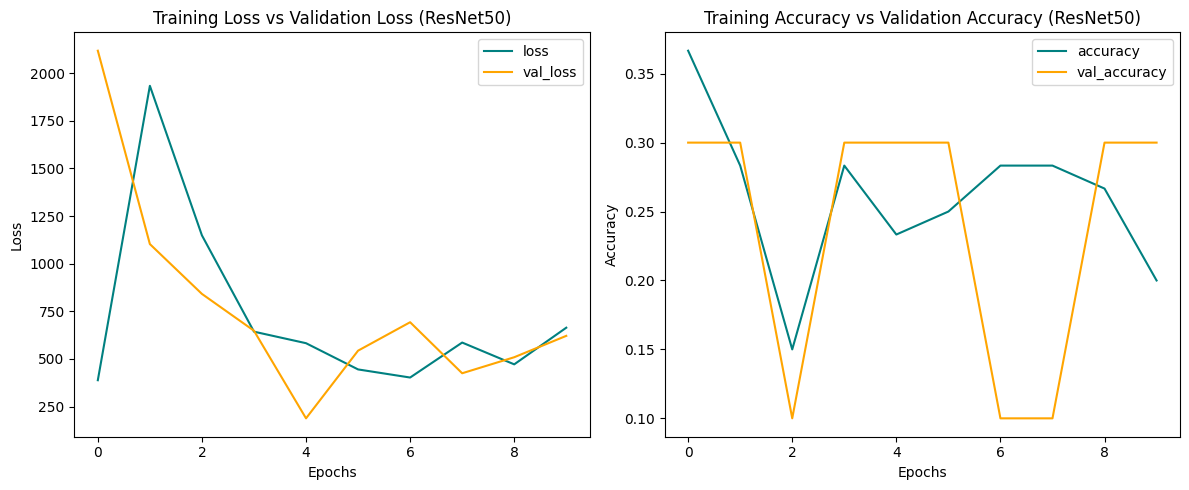

Evaluation on test set for ResNet50
1/1 [==============================] - 1s 651ms/step - loss: 312.4554 - accuracy: 0.3000
Test Loss: 312.45538330078125
Test Accuracy: 0.30000001192092896


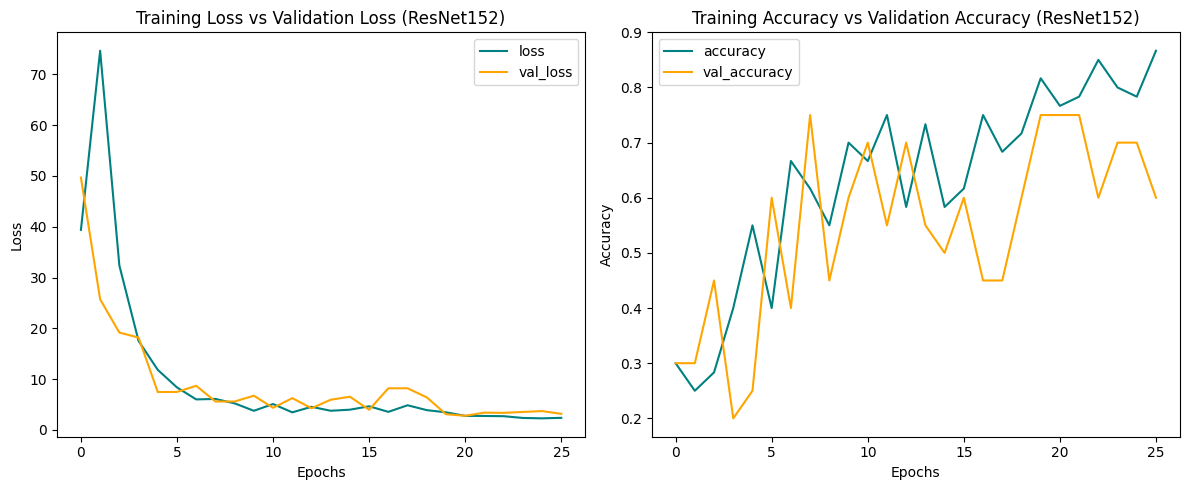

Evaluation on test set for ResNet152
1/1 [==============================] - 2s 2s/step - loss: 3.7634 - accuracy: 0.7000
Test Loss: 3.7633934020996094
Test Accuracy: 0.699999988079071


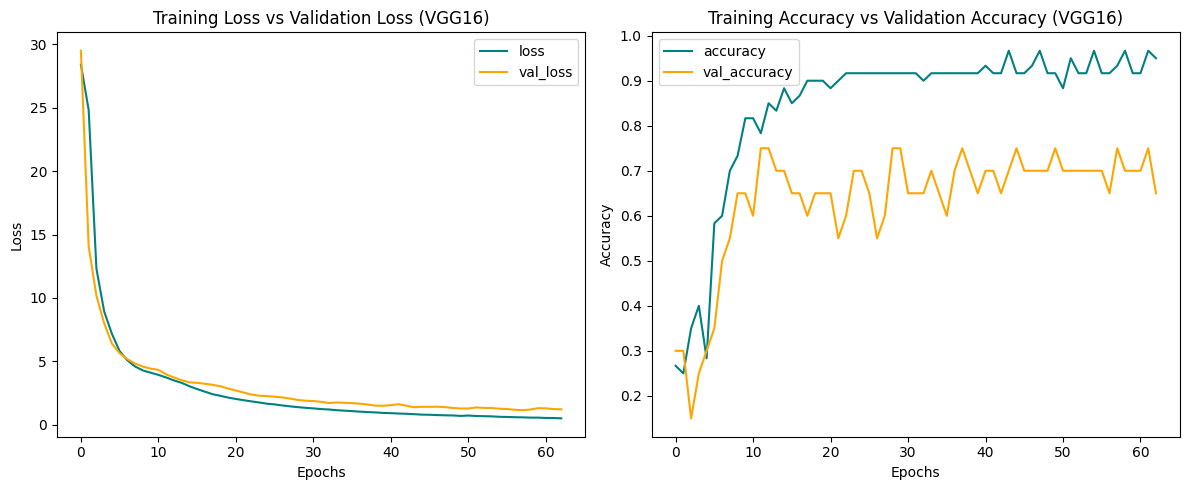

Evaluation on test set for VGG16
1/1 [==============================] - 1s 1s/step - loss: 1.0762 - accuracy: 0.8000
Test Loss: 1.0761545896530151
Test Accuracy: 0.800000011920929


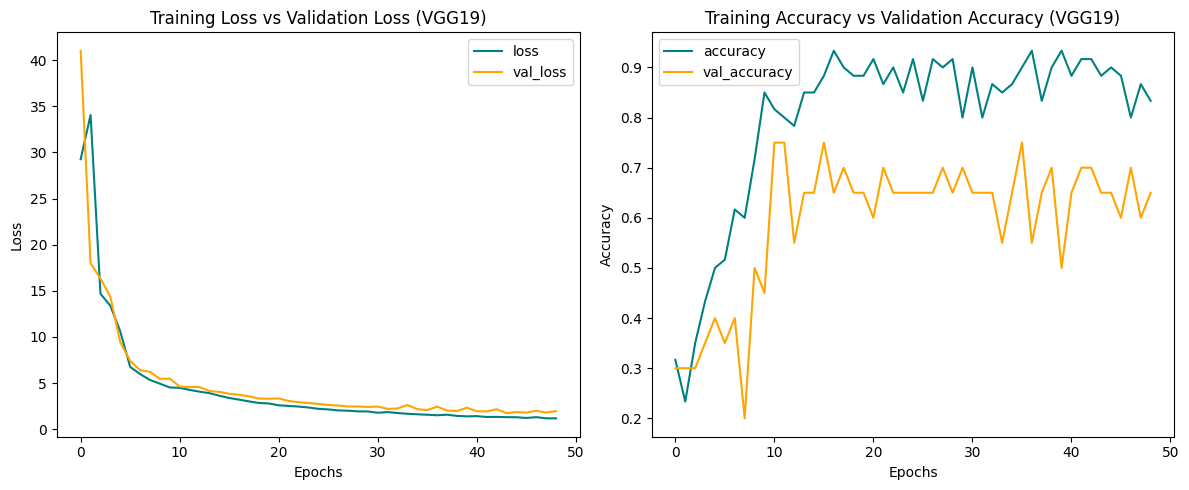

Evaluation on test set for VGG19
1/1 [==============================] - 2s 2s/step - loss: 1.6400 - accuracy: 0.6500
Test Loss: 1.639976143836975
Test Accuracy: 0.6499999761581421


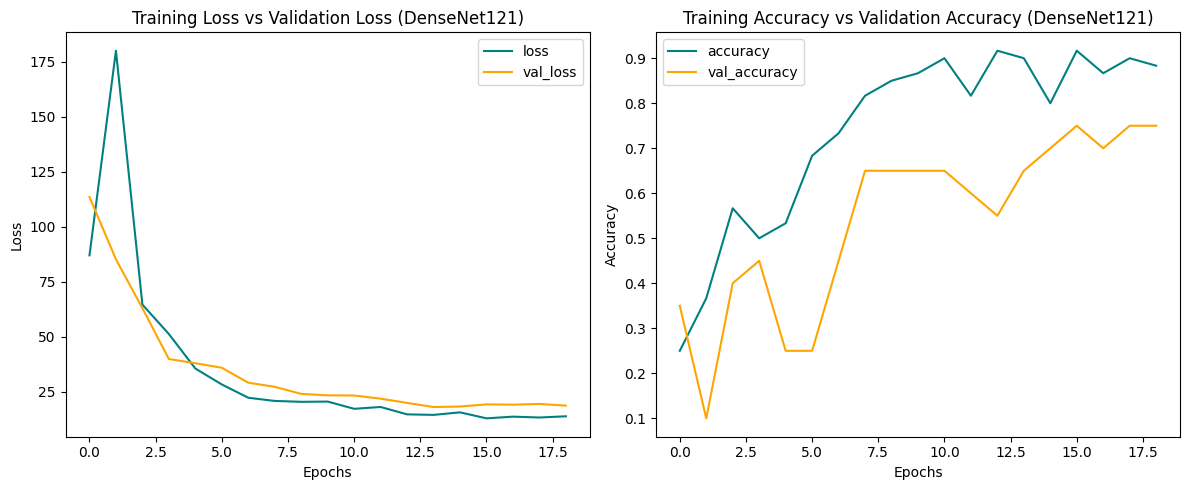

Evaluation on test set for DenseNet121
1/1 [==============================] - 1s 1s/step - loss: 15.2021 - accuracy: 0.8000
Test Loss: 15.202115058898926
Test Accuracy: 0.800000011920929


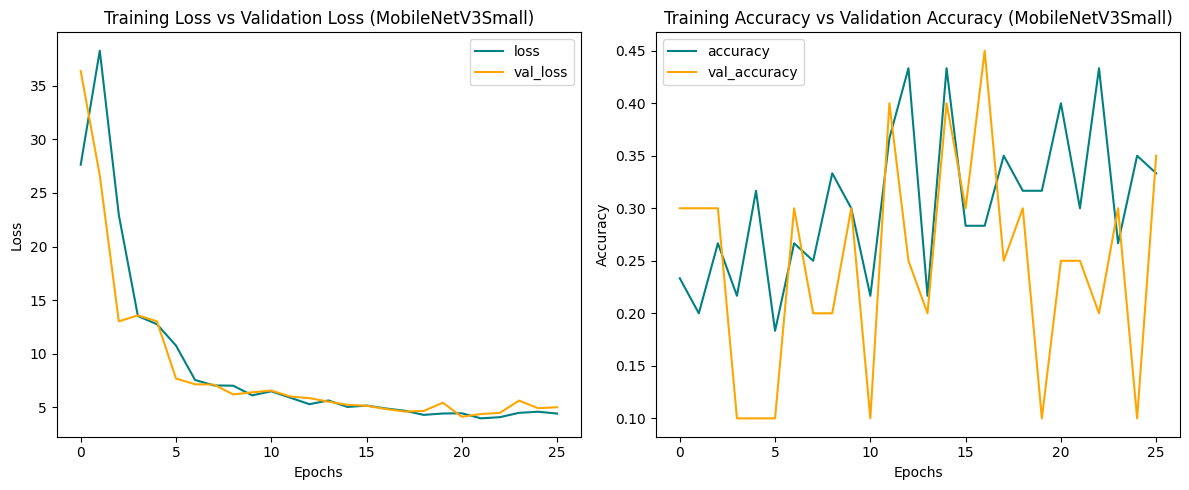

Evaluation on test set for MobileNetV3Small
1/1 [==============================] - 0s 116ms/step - loss: 4.0313 - accuracy: 0.3000
Test Loss: 4.031257629394531
Test Accuracy: 0.30000001192092896


In [73]:
fullEval("ResNet50" , head_ResNet50, history_resnet50,x_test, y_test)
fullEval("ResNet152", head_ResNet152, history_resnet152,x_test, y_test)
fullEval("VGG16", head_VGG16, history_VGG16,x_test, y_test)
fullEval("VGG19", head_VGG19, history_VGG19,x_test, y_test)
fullEval("DenseNet121" ,head_densenet, history_densenet,x_test, y_test)
fullEval("MobileNetV3Small" ,head_mobilenet_v3, history_mobilenet_v3,x_test, y_test)